# Baseline Training: Deep MLP

В этом ноутбуке мы:
1. Создадим глубокую MLP модель для классификации текстов
2. Обучим модель на датасете AG News с использованием PyTorch Lightning
3. Запустим профилировщик для анализа производительности
4. Измерим скорость обучения и потребление ресурсов

**Цель:** Получить baseline результаты для дальнейшего сравнения с оптимизированными версиями.


In [1]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.profilers import SimpleProfiler, AdvancedProfiler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time

from text_features_data import TextFeaturesDataModule
from mlp_model import DeepMLP
from lightning_module import TextClassificationModule

sns.set_style('whitegrid')
%matplotlib inline

# Проверяем наличие GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")


Using device: cuda
GPU: NVIDIA L40
GPU memory: 44.38 GB


## 1. Загрузка данных

Загрузим подготовленный датасет AG News.


In [2]:
# Создаем DataModule
dm = TextFeaturesDataModule(
    max_features=20000,
    batch_size=256,  # Можно увеличить для GPU
    use_bigrams=True,
    cache_dir="./cache",
    num_workers=4,  # Для ускорения загрузки
)

# Загружаем данные
dm.prepare_data()
dm.setup()

print(f"\nDataset info:")
print(f"  Input dim: {dm.input_dim}")
print(f"  Num classes: {dm.n_classes}")
print(f"  Train samples: {len(dm.train_dataset)}")
print(f"  Val samples: {len(dm.val_dataset)}")
print(f"  Batch size: {dm.batch_size}")


Loading from cache...
Dataset loaded: classes=4, features=20005, train=108460, val=19140

Dataset info:
  Input dim: 20005
  Num classes: 4
  Train samples: 108460
  Val samples: 19140
  Batch size: 256


## 2. Создание модели

Создадим глубокую MLP модель для классификации.


In [3]:
# Создаем модель
model = DeepMLP(
    input_dim=dm.input_dim,
    output_dim=dm.n_classes,
    hidden_dims=[2048, 1024, 512, 256, 128],  # Глубокая сеть
    activation='silu',
    dropout=0.3,
    use_batch_norm=True,
)

# Создаем Lightning модуль
lightning_model = TextClassificationModule(
    model=model,
    lr=1e-3,
    optimizer_type='adam',
    weight_decay=1e-5,
    num_classes=dm.n_classes,
)

print(f"\nModel parameters: {model.get_num_parameters():,}")


Model architecture:
  Hidden dims: [2048, 1024, 512, 256, 128]
  Activation: relu
  Dropout: 0.3
  Batch norm: True

Model parameters: 43,767,940


## 3. Обучение с профилировщиком

Запустим обучение с Simple Profiler для анализа производительности.


In [4]:
# Callbacks
checkpoint_callback = ModelCheckpoint(
    monitor='val_f1',
    mode='max',
    save_top_k=1,
    filename='best-{epoch:02d}-{val_f1:.4f}',
    dirpath='./checkpoints',
)

early_stopping = EarlyStopping(
    monitor='val_f1',
    patience=5,
    mode='max',
)

# Logger
logger = CSVLogger('logs', name='baseline')

# Profiler
profiler = SimpleProfiler(dirpath='./profiler', filename='baseline_profile')

# Trainer
trainer = pl.Trainer(
    max_epochs=10,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    devices=1,
    callbacks=[checkpoint_callback, early_stopping],
    logger=logger,
    profiler=profiler,
    log_every_n_steps=50,
    enable_progress_bar=True,
)

# Обучение
print("Starting training...")
start_time = time.time()
trainer.fit(lightning_model, dm)
training_time = time.time() - start_time

print(f"\nTraining completed in {training_time:.2f} seconds ({training_time/60:.2f} minutes)")


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA L40') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Starting training...


/home/tam2511/venvs/train_py10/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:658: Checkpoint directory /home/tam2511/mounts/0/arcadia/market/robotics/cv/ml/user_data/shad/dl2025/lesson5/seminar/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Loading from cache...
Dataset loaded: classes=4, features=20005, train=108460, val=19140



  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | DeepMLP            | 43.8 M | train
1 | criterion | CrossEntropyLoss   | 0      | train
2 | train_acc | MulticlassAccuracy | 0      | train
3 | val_acc   | MulticlassAccuracy | 0      | train
4 | val_f1    | MulticlassF1Score  | 0      | train
---------------------------------------------------------
43.8 M    Trainable params
0         Non-trainable params
43.8 M    Total params
175.072   Total estimated model params size (MB)
23        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/tam2511/mounts/0/arcadia/market/robotics/cv/ml/user_data/shad/dl2025/lesson5/seminar/text_features_data.py:45: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  x = torch.FloatTensor(self.X[idx])
/home/tam2511/mounts/0/arcadia/market/robotics/cv/ml/user_data/shad/dl2025/lesson5/seminar/text_features_data.py:45: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppress

Training: |          | 0/? [00:00<?, ?it/s]

/home/tam2511/mounts/0/arcadia/market/robotics/cv/ml/user_data/shad/dl2025/lesson5/seminar/text_features_data.py:45: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  x = torch.FloatTensor(self.X[idx])


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


Training completed in 74.13 seconds (1.24 minutes)


## 4. Анализ результатов

Посмотрим на метрики обучения.


In [5]:
# Загружаем логи
from pathlib import Path

log_dir = Path('logs/baseline')
metrics_file = list(log_dir.glob('*/metrics.csv'))[0]
metrics = pd.read_csv(metrics_file)

# Показываем доступные колонки
print("Available columns:")
print(metrics.columns.tolist())
print("\n" + "="*60 + "\n")

# Получаем метрики по эпохам
val_metrics = metrics.dropna(subset=['val_loss'])

# Для train метрик ищем колонки с train_loss и train_acc
train_loss_col = [c for c in metrics.columns if 'train_loss' in c and 'epoch' in c]
train_acc_col = [c for c in metrics.columns if 'train_acc' in c and 'epoch' in c]

train_metrics = None
if train_loss_col:
    train_metrics = metrics.dropna(subset=[train_loss_col[0]])
    print("Training metrics:")
    cols_to_show = ['epoch', train_loss_col[0]]
    if train_acc_col:
        cols_to_show.append(train_acc_col[0])
    print(train_metrics[cols_to_show].tail())
else:
    print("Training metrics: Not found")

print("\nValidation metrics:")
print(val_metrics[['epoch', 'val_loss', 'val_acc', 'val_f1']].tail())

# Лучшие результаты
best_epoch = val_metrics.loc[val_metrics['val_f1'].idxmax()]
print(f"\nBest results (epoch {int(best_epoch['epoch'])}):")
print(f"  Val Loss: {best_epoch['val_loss']:.4f}")
print(f"  Val Accuracy: {best_epoch['val_acc']:.4f}")
print(f"  Val F1: {best_epoch['val_f1']:.4f}")


Available columns:
['epoch', 'step', 'train_acc', 'train_loss_epoch', 'train_loss_step', 'val_acc', 'val_f1', 'val_loss']


Training metrics:
    epoch  train_loss_epoch
19      1          0.154720
30      2          0.098503
40      3          0.071077
51      4          0.057526
61      5          0.050054

Validation metrics:
    epoch  val_loss   val_acc    val_f1
18      1  0.244481  0.918704  0.918600
29      2  0.280265  0.917294  0.917376
39      3  0.315389  0.916614  0.916617
50      4  0.339800  0.912644  0.912751
60      5  0.358320  0.911703  0.911654

Best results (epoch 0):
  Val Loss: 0.2270
  Val Accuracy: 0.9224
  Val F1: 0.9223


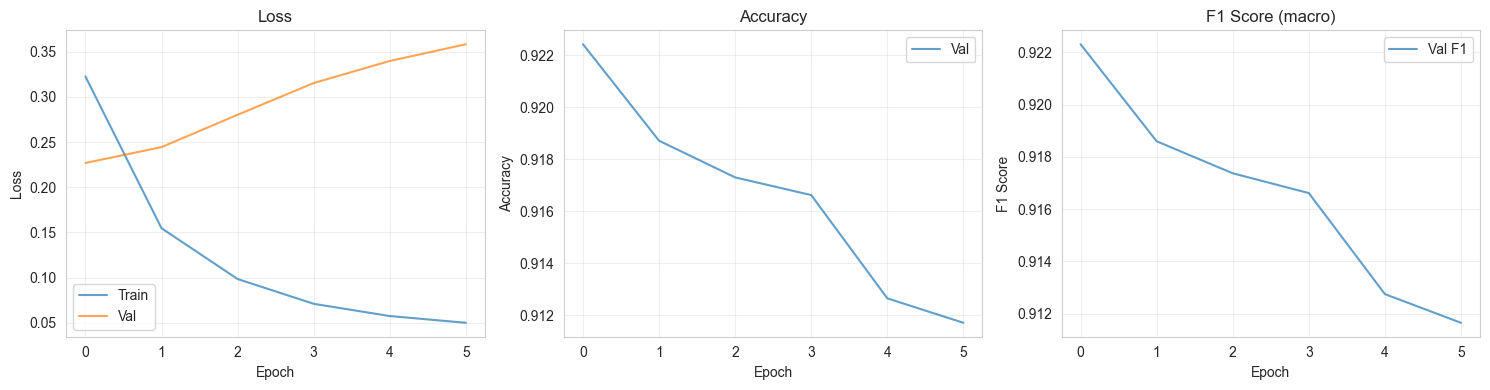

In [6]:
# Визуализация learning curves
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Loss
if train_loss_col and train_metrics is not None:
    axes[0].plot(train_metrics['epoch'], train_metrics[train_loss_col[0]], label='Train', alpha=0.7)
axes[0].plot(val_metrics['epoch'], val_metrics['val_loss'], label='Val', alpha=0.7)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
if train_acc_col and train_metrics is not None:
    axes[1].plot(train_metrics['epoch'], train_metrics[train_acc_col[0]], label='Train', alpha=0.7)
axes[1].plot(val_metrics['epoch'], val_metrics['val_acc'], label='Val', alpha=0.7)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# F1 Score
axes[2].plot(val_metrics['epoch'], val_metrics['val_f1'], label='Val F1', alpha=0.7)
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('F1 Score')
axes[2].set_title('F1 Score (macro)')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 5. Анализ профилировщика

Посмотрим на результаты профилирования.


In [7]:
# Читаем результаты профилирования
profiler_file = Path('./profiler/baseline_profile.txt')

if profiler_file.exists():
    with open(profiler_file, 'r') as f:
        profile_content = f.read()
    
    print("Profiler results:")
    print("="*60)
    print(profile_content)
else:
    print("Profiler file not found. Profiler summary:")
    print(profiler.summary())


Profiler file not found. Profiler summary:
FIT Profiler Report

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                             	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                   